In [1]:
# imports
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
# author - Mathuranathan Viswanathan (gaussianwaves.com
# this code is part of the book "Digital Modulations using Python"
# https://www.gaussianwaves.com/2015/06/how-to-generate-awgn-noise-in-matlaboctave-without-using-in-built-awgn-function/

from numpy import isrealobj,sqrt,log
from numpy.random import standard_normal
from typing import Any, Callable

def awgn(s,SNRdB,L=1):
    """
    AWGN channel
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal 's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power spectral density N0 of noise added
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB) for the received signal
        ms: if receiving single numbers, can compute the 'mean squared' beforehand
        L : oversampling factor (applicable for waveform simulation) default L = 1.
    Returns:
        n : generated awgn noise (n), or
        r : received signal vector (r=s+n)
"""

    gamma = 10**(SNRdB/10) #SNR to linear scale

    if s.dim == 1:# if s is single dimensional vector
        P=L*torch.sum(torch.absolute(s)**2)/s.size(dim=0) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*torch.sum(torch.sum(torch.absolute(s)**2))/s.size(dim=0) # if s is a matrix [MxN]

    N0=P/gamma # Find the noise spectral density

    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*torch.normal(0, 1, size=s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(torch.normal(0, 1, size=s.shape)+1j*torch.normal(0, 1, size=s.shape))

    r = s + n # received signal
    return r


def bsc(c, p):
    pm = torch.zeros(c.size(dim=0))
    pm = pm + p
    rands = torch.bernoulli(pm)
    return torch.fmod(c + rands, 2)

# Log likelihood ratio calculations for different channels

def bsc_llr(p: float) -> Callable:
    """
    bsc llr is defined as:
        L(c_i) = log(Pr(c_i=0| y_i) / Pr(c_i=1| y_i)) = (-1)^y log((1-p)/p)
    :param float p: the llr is parameterized by the bit flip probability of the channel p.
    :returns: return a callable which accepts a single argument - y_i (a bit from the channel), and returns its llr
    """
    return lambda y: torch.pow(-1, y) * log((1-p)/p)

def awgn_llr(snrDB=1, m=0) -> Callable:
    """
    awgn llr is defined as:
      L(c_i) = log(Pr(c_i=0| y_i) / Pr(c_i=1| y_i)) =
      log \left( \frac{ \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(0 - \mu)^2}{2 \sigma^2}} }{ \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(1 - \mu)^2}{2 \sigma^2}} } \right) =
      log \left( \frac{ e^{- \frac{(0 - \mu)^2}{2 \sigma^2}} }{  e^{- \frac{(1 - \mu)^2}{2 \sigma^2}} } \right) =
      log \left( e^{- \frac{(0 - \mu)^2}{2 \sigma^2}} \right) - log \left(  e^{- \frac{(1 - \mu)^2}{2 \sigma^2}} \right) =
      - \frac{(0 - \mu)^2}{2 \sigma^2} + \frac{(1 - \mu)^2}{2 \sigma^2} =
      \frac{\mu^2 - 2\mu + 1 - \mu^2}{2 \sigma^2} =
      \frac{1 - 2 \mu}{2 \sigma^2}

    """
    gamma = 10**(snrDB/10)
    # snr = 10 log(signal_variance / noise_variance)
    # signal_variance = 10**(snr/10) * noise_variance = gamma * noise_variance
    return lambda y: torch.pow(-1, torch.round(y)) * (1 - 2 * m) * gamma / 2


In [3]:
# Supporting functions
def ber(c, est):
  return torch.sum(torch.fmod(c + est, 2)) / c.size(dim=0)


def customCrossEntropyLoss(c, est):
  n = c.size(dim=0)
  loss = c * torch.log(est) + (1-c) * torch.log(1 - est)
  loss = torch.sum(loss)
  loss = - loss / n
  print("LOSS: loss")
  return loss

In [5]:
# Belief Propagation Model
class BPModel(nn.Module):
  def __init__(self,
            pcm,
            L=5):

    super(BPModel, self).__init__()

    self.L = L

    # count and form edges
    self.E = torch.count_nonzero(pcm)
    self.edges_to_vc = [] # E-length array of the index of "v" and "c" associated with the edge, for LLR
    for i_c, pcm_c in enumerate(pcm):
      for i_v, pcm_cv in enumerate(pcm_c):
        if pcm_cv == 1:
          self.edges_to_vc.append((i_v, i_c))

    # initialize parameters
    self.W_e = nn.Parameter(torch.ones(L+1, self.E, requires_grad=True)*1e-2)
    # self.W_e = nn.Parameter(torch.randn(L+1, self.E, requires_grad=True)*1e-2)

    # initialize zeros
    self.x_v = torch.zeros(L+1, self.E)
    self.x_c = torch.zeros(L+1, self.E)

  def initialize(self, codeword, channel_model=lambda y:y):
    """
    initializes a codeword for processing
    """
    self.channel_model = channel_model

    # get number of bits in codeword
    self.N = codeword.size(dim=0)

    # initialize parameters
    self.W_llr = nn.Parameter(torch.ones(self.L+1, self.N, requires_grad=True)*1e-2)
    # self.W_llr = nn.Parameter(torch.randn(self.L+1, self.N, requires_grad=True)*1e-2)

    # calculate llr values for each bit in codeword
    self.llr_v = [] # N-length array of calculated LLR values
    for v in codeword:
      llr = self.channel_model(v)
      self.llr_v.append(llr)
    self.llr_v = torch.stack(self.llr_v)

  def v_to_c(self, layer_num, edge_num):
    """
    computes outgoing messages from a "variable" node
    """
    llr = self.llr_v[self.edges_to_vc[edge_num][0]]
    curr_v, _ = self.edges_to_vc[edge_num]

    incoming_messages = torch.Tensor([msg for idx, msg in enumerate(self.x_c[layer_num]) if curr_v == self.edges_to_vc[idx][0] and idx != edge_num])
    x = llr * self.W_llr[layer_num][curr_v] + torch.sum(torch.Tensor([msg * self.W_e[layer_num][edge_num] for msg in incoming_messages]))
    self.x_v[layer_num+1][edge_num] = x
    # print(f"v_to_c (layer {layer_num}, edge: {edge_num}): {x}")
    return x

  def c_to_v(self, layer_num, edge_num):
    """
    computes outgoing messages from a "check" node
    """
    def phi(x):
      return -torch.log(torch.tanh(x/2))

    _, curr_c = self.edges_to_vc[edge_num]

    incoming_messages = torch.Tensor([msg for idx, msg in enumerate(self.x_v[layer_num]) if curr_c == self.edges_to_vc[idx][1] and idx != edge_num])
    x = torch.prod(torch.sign(incoming_messages))*phi(torch.sum(phi(torch.absolute(incoming_messages))))
    self.x_c[layer_num+1][edge_num] = x
    # print(f"c_to_v (layer {layer_num}, edge: {edge_num}): {x}")
    return x

  def estimate(self, layer):
    """
    computes estimation based on llr value
    """
    v_sums = []
    for v in range(self.N):
      received_messages = torch.Tensor([x for en, x in enumerate(self.x_c[layer]) if self.edges_to_vc[en][0] == v])
      v_sums.append(torch.sum(received_messages))
    v_sums = torch.stack(v_sums)

    llr = self.llr_v + v_sums
    # llr = nn.Sigmoid()(llr)
    bin_est = torch.Tensor([1 if node_llr < 0 else 0 for node_llr in llr])
    return bin_est
      
  def forward(self):
    """
    feed forward network
    """
    # run network
    for ln in range(self.L):
      for en in range(self.E):
        self.v_to_c(ln, en)
        self.c_to_v(ln, en)

    # compute output
    o = self.estimate(self.L)
    return o


In [6]:
# TRAINER AND RUNNER
class Trainer:
  cw_count = 0
  codewords = []

  def __init__(self, bpModel):
    self.bpModel = bpModel


  def setPCM(self, pcm):
    self.H = pcm
    self.h_len = pcm.size(dim=0)


  def create_codewords(self, max=20):
    if self.H == None:
      print("** ERROR ** Did not initialize a parity check matrix!!")
      return

    self.max_codewords = max

    for i in range(self.h_len):
      self._cw_recurse(i+1, self.H[i])

  def _cw_recurse(self, l, add):
    if self.cw_count >= self.max_codewords: return
    self.codewords.append(add)
    self.cw_count += 1
    for j in range(l, self.h_len):
      next = (add + self.H[j]) % 2
      self._cw_recurse(j+1, next)


  def run_experiments_bsc(self, prob_options=[0.1,0.2,0.3]):
    if self.H == None:
      print("** ERROR ** Did not initialize a parity check matrix!!")
      return

    if len(self.codewords) == 0:
      self.create_codewords()

    # do experiments
    ber_base = 0
    ber_for_ps = {}
    bers_for_ps = {}
    estimations_for_ps = {}

    # test for different bit flip probabilities
    for p in prob_options:
      total_ber = 0
      bers = []
      estimations = []

      # test for all codewords provided
      for cw in self.codewords:
        true_c = cw
        # assume bsc channel with given p
        c = bsc(true_c, p)
        model = bsc_llr(p)

        # CALCULATE BASIS
        res_est = torch.Tensor([0 if node_llr < 0.5 else 1 for node_llr in c])
        res_ber = ber(true_c, res_est)
        ber_base += res_ber

        #  RUN HERE
        self.bpModel.initialize(c, channel_model=model)
        res_est_bp = self.bpModel.forward()
        estimations.append(res_est_bp)

        res_check_bp = torch.matmul(self.H.T, res_est_bp) % 2
        res_ber_bp = ber(true_c, res_est_bp)
        # print(f"code: {true_c} \n    resbp: {res_est_bp} \n    parity check: {res_check_bp} \n    ber: {res_ber_bp}")
        total_ber += res_ber_bp
        bers.append(res_ber_bp)

      total_ber /= len(self.codewords)
      ber_for_ps[p] = total_ber
      bers_for_ps[p] = bers
      estimations_for_ps[p] = estimations

    ber_base /= len(self.codewords) * len(prob_options)

    # print(f"base ber: {ber_base}")
    # print(ber_for_ps)

    return ber_base, ber_for_ps, bers_for_ps, estimations_for_ps

  def run_experiments_awgn(self, snrDB_options=[1,2,3,4,5,6]):
    if self.H == None:
      print("** ERROR ** Did not initialize a parity check matrix!!")
      return

    if len(self.codewords) == 0:
      self.create_codewords()

    # do experiments
    ber_base = 0
    ber_for_snrDB = {}
    bers_for_snrDB = {}
    estimations_for_snrDB = {}

    # test for different signal-to-noise ratios
    for snrDB in snrDB_options:
      total_ber = 0
      bers = []
      estimations = []

      # test for all codewords provided
      for cw in self.codewords:
        true_c = cw
        # Assume an AWGN channel with given SNR
        c = awgn(true_c, snrDB)
        ave = torch.sum(c)/c.size(dim=0)
        model = awgn_llr(snrDB, ave)

        # CALCULATE BASIS
        res_est = torch.Tensor([0 if node_llr < 0.5 else 1 for node_llr in c])
        res_ber = ber(true_c, res_est)
        ber_base += res_ber

        # RUN HERE
        self.bpModel.initialize(c, channel_model=model)
        res_est_bp = self.bpModel.forward()
        estimations.append(res_est_bp)

        res_check_bp = torch.matmul(self.H, res_est_bp) % 2
        res_ber_bp = ber(true_c, res_est_bp)
        # print(f"code: {true_c} \n    resbp: {res_est_bp} \n    parity check: {res_check_bp} \n    ber: {res_ber_bp}")
        total_ber += res_ber_bp
        bers.append(res_ber_bp)

      total_ber /= len(self.codewords)
      ber_for_snrDB[snrDB] = total_ber
      bers_for_snrDB[snrDB] = bers
      estimations_for_snrDB[snrDB] = estimations

    ber_base /= len(self.codewords) * len(snrDB_options)

    # print(f"base ber: {ber_base}")
    # print(ber_for_snrDB)

    return ber_base, ber_for_snrDB, bers_for_snrDB, estimations_for_snrDB


  def train_awgn(self, snrDB=1, datanum=10, epochs=10):
    if self.H == None:
      print("** ERROR ** Did not initialize a parity check matrix!!")
      return

    train_op = torch.optim.RMSprop(self.bpModel.parameters(), 0.001)

    # use zero codewords for training
    true_c = torch.zeros(self.H.size(dim=1))
    train_data = []

    for _ in range(10):
      # create test data
      c = awgn(true_c, snrDB)
      train_data.append(c)

    for epoch in range(10):
      # training loops
      loss_ = []
      for data in train_data:
          ave = torch.sum(c)/c.size(dim=0)
          channel_model = awgn_llr(snrDB, ave)

          self.bpModel.initialize(data, channel_model=channel_model)
          estim = self.bpModel.forward()
          # loss = customCrossEntropyLoss(true_c, estim)
          loss = nn.CrossEntropyLoss()(estim, true_c)
          loss_.append(loss)
          train_op.zero_grad()
          loss.backward()
          train_op.step()

      print("Training loss for {} epoch: {}".format(epoch, torch.mean(torch.tensor(loss_))))



In [7]:
# C(63,36)
h_raw = "1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1;"
h_raw = h_raw.split(";")
H = []

for idx, h_raw_row in enumerate(h_raw):
  if (h_raw_row == ""): break
  mid = h_raw_row.strip()
  mid = mid.split(" ")
  H.append([float(i) for i in mid])
H = torch.Tensor(H)

bp = BPModel(H, L=5)

main = Trainer(bp)
main.setPCM(H)

res_base_totber, res_noml_totber, res_noml_bers, res_noml_estimations = main.run_experiments_awgn([1, 2, 3, 4, 5, 6])
res_base_totber2, res_wiml_totber, res_wiml_bers, res_wiml_estimations = main.run_experiments_awgn([1, 2.5, 3.5, 4.5, 5.5, 6.5])


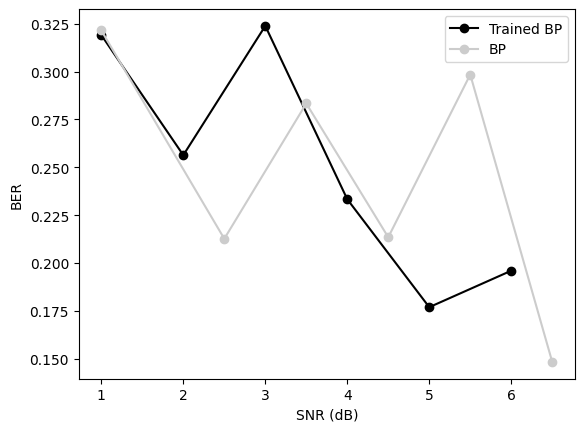

In [8]:
import numpy as np
import matplotlib.pyplot as plt
# data = res_noml_totber.values

x1 = list(res_noml_totber.keys())
y1 = list(res_noml_totber.values())

x2 = list(res_wiml_totber.keys())
y2 = list(res_wiml_totber.values())

# plt.scatter(x,y)
plt.plot(x1, y1, '-o', label='Trained BP', color="0")
plt.plot(x2, y2, '-o', label='BP', color="0.8")

plt.ylabel('BER')
plt.xlabel('SNR (dB)')

plt.legend()
plt.show()


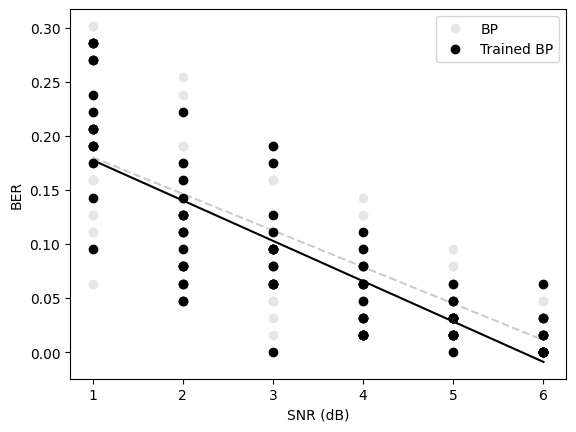

In [9]:
from os import listxattr
import numpy as np
import matplotlib.pyplot as plt
# data = res_noml_totber.values

x1 = list(res_noml_bers.keys())
y1 = list(res_noml_bers.values())
y1 = np.array(y1)

x_all = np.array([])
y_all = np.array([])

for idx, z in enumerate(y1):
  z_y = z
  z_x = np.ones(len(z_y)) * x1[idx]
  x_all = np.concatenate((x_all, z_x), axis=None)
  y_all = np.concatenate((y_all, z_y), axis=None)

plt.plot(x_all, y_all, 'o', label="BP", color="0.9")
a, b = np.polyfit(x_all, y_all, 1)
plt.plot(x_all, a*x_all+b, color="0.8", linestyle="dashed")

x2 = list(res_wiml_bers.keys())
y2 = list(res_wiml_bers.values())
y2 = np.array(y2)

x_all = np.array([])
y_all = np.array([])

for idx, z in enumerate(y2):
  z_y = z
  z_x = np.ones(len(z_y)) * x1[idx]
  x_all = np.concatenate((x_all, z_x), axis=None)
  y_all = np.concatenate((y_all, z_y), axis=None)

plt.plot(x_all, y_all, 'o', label="Trained BP", color="0")
a, b = np.polyfit(x_all, y_all, 1)
plt.plot(x_all, a*x_all+b, color="0")


#add line of best fit to plot
# a1, b1 = np.polyfit(x1, y1, 1)
# plt.plot(x1, a1*x1+b1)
# a2, b2 = np.polyfit(x2, y2, 1)
# plt.plot(x2, a2*x2+b2)

plt.ylabel('BER')
plt.xlabel('SNR (dB)')

plt.legend()
plt.show()


In [7]:
# C(15,11)
h_raw2 = "1 0 0 1 1 0 1 0 1 1 1 1 0 0 0; 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0; 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0; 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1;"
h_raw2 = h_raw2.split(";")
H2 = []

for idx, h_raw_row in enumerate(h_raw2):
  if (h_raw_row == ""): break
  mid = h_raw_row.strip()
  mid = mid.split(" ")
  H2.append([float(i) for i in mid])
H2 = torch.Tensor(H2)

bp2 = BPModel(H2, L=5)

main2 = Trainer(bp2)
main2.setPCM(H2)

_, res_noml_totber2, res_noml_bers2, res_noml_estimations2 = main2.run_experiments_awgn([1, 2, 3, 4, 5, 6])
_, res_wiml_totber2, res_wiml_bers2, res_wiml_estimations2 = main2.run_experiments_awgn([1, 2.5, 3.5, 4.5, 5.5, 6.5])


{1: [tensor(0.1333), tensor(0.7333), tensor(0.4667), tensor(0.8000), tensor(0.2667), tensor(0.2000), tensor(0.7333), tensor(0.6667), tensor(0.7333), tensor(0.6667), tensor(0.6667), tensor(0.2000), tensor(0.6667), tensor(0.2000), tensor(0.7333)], 2: [tensor(0.2667), tensor(0.7333), tensor(0.6000), tensor(0.8000), tensor(0.0667), tensor(0.2000), tensor(0.6667), tensor(0.6667), tensor(0.1333), tensor(0.2000), tensor(0.8667), tensor(0.2000), tensor(0.4000), tensor(0.8000), tensor(0.6667)], 3: [tensor(0.2000), tensor(0.8667), tensor(0.8000), tensor(0.2000), tensor(0.2000), tensor(0.8667), tensor(0.2000), tensor(0.9333), tensor(0.8667), tensor(0.1333), tensor(0.8667), tensor(0.8667), tensor(0.2000), tensor(0.1333), tensor(0.2000)], 4: [tensor(0.9333), tensor(0.), tensor(0.1333), tensor(0.8000), tensor(0.7333), tensor(0.8000), tensor(0.9333), tensor(0.7333), tensor(0.2000), tensor(0.9333), tensor(0.1333), tensor(0.2667), tensor(0.2000), tensor(0.7333), tensor(0.2000)], 5: [tensor(0.8000), ten

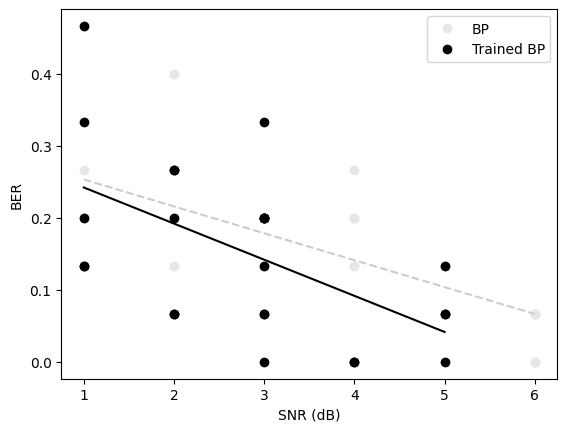

In [9]:
from os import listxattr
import numpy as np
import matplotlib.pyplot as plt
# data = res_noml_totber.values

print(res_noml_bers2)
print(res_wiml_bers2)

x1 = list(res_noml_bers2.keys())
y1 = list(res_noml_bers2.values())
y1 = np.array(y1)

x_all = np.array([])
y_all = np.array([])

for idx, z in enumerate(y1):
  z_y = z
  z_x = np.ones(len(z_y)) * x1[idx]
  x_all = np.concatenate((x_all, z_x), axis=None)
  y_all = np.concatenate((y_all, z_y), axis=None)

plt.plot(x_all, y_all, 'o', label="BP", color="0.9")
a, b = np.polyfit(x_all, y_all, 1)
plt.plot(x_all, a*x_all+b, color="0.8", linestyle="dashed")

x2 = list(res_wiml_bers2.keys())
y2 = list(res_wiml_bers2.values())
y2 = np.array(y2)

x_all = np.array([])
y_all = np.array([])

for idx, z in enumerate(y2):
  z_y = z
  z_x = np.ones(len(z_y)) * x1[idx]
  x_all = np.concatenate((x_all, z_x), axis=None)
  y_all = np.concatenate((y_all, z_y), axis=None)

plt.plot(x_all, y_all, 'o', label="Trained BP", color="0")
a, b = np.polyfit(x_all, y_all, 1)
plt.plot(x_all, a*x_all+b, color="0")

plt.ylabel('BER')
plt.xlabel('SNR (dB)')

plt.legend()
plt.show()
